In [1]:
import io
from pathlib import Path
import pickle

import matplotlib.pyplot as plt

import torch
%matplotlib inline

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

run_id = 'SUB-849'
path = Path('../data/models/checkpoints', run_id, 'embeddings.pkl')

# feature_bank, feature_labels, embedding, targets, label_names = pickle.load(open('embeds_379-cifar100.pkl', 'rb'))
# feature_bank, feature_labels, embedding, targets, label_names = pickle.load(open('embeds_379.pkl', 'rb'))
# feature_bank, feature_labels, embedding, targets, label_names = pickle.load(open('embeds_819.pkl', 'rb'))
# feature_bank, feature_labels, embedding, targets, label_names = pickle.load(open('embeds_820.pkl', 'rb'))
feature_bank, feature_labels, embedding, targets, label_names = CPU_Unpickler(open(path, 'rb')).load()

# pickle.dump((feature_bank, feature_labels, embedding, targets, self.dataset['train'].label_names), open('embeds_820.pkl' , 'wb'))

In [2]:
print(feature_bank.shape)

A = feature_bank.T
U, S, V = torch.pca_lowrank(A, q=50, center=True, niter=2)
X = U.cpu().numpy()
y = feature_labels.cpu().numpy()

torch.Size([2048, 5000])


In [3]:
import numpy as np

E = ((embedding - A.mean(axis=0)) @ V @ torch.diag(1 / S)).cpu().numpy()
Ey = targets.cpu().numpy()

XE = np.concatenate((X, E))

In [4]:
import time
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
t0 = time.time()
XE_reduced = tsne.fit_transform(XE)
t1 = time.time()

X_reduced = XE_reduced[:len(X)]
E_reduced = XE_reduced[len(X):]

t1 - t0

/home/ook/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ook/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


65.23036313056946

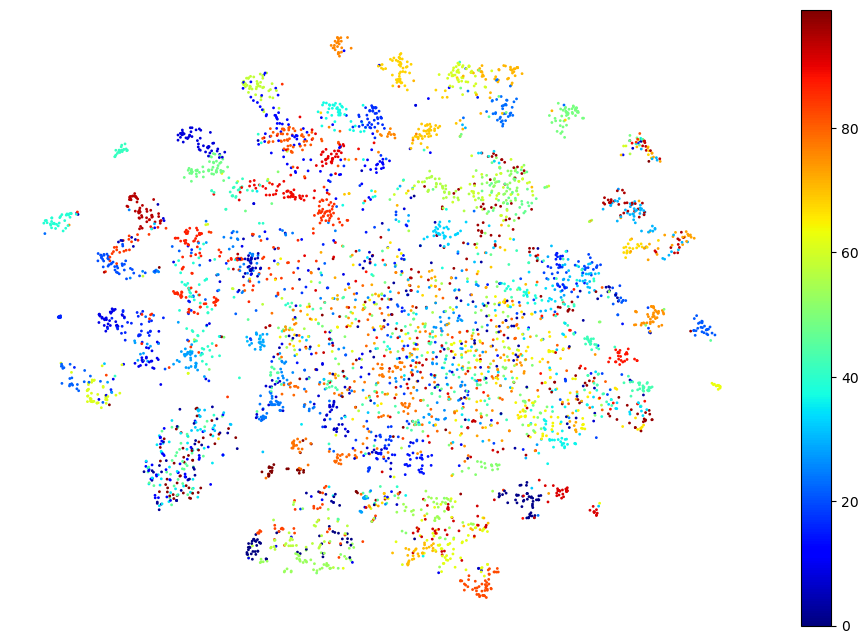

In [5]:
plt.figure(figsize=(12, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='jet', marker='o', s=1.0)
plt.colorbar()
plt.axis('off')
plt.show()

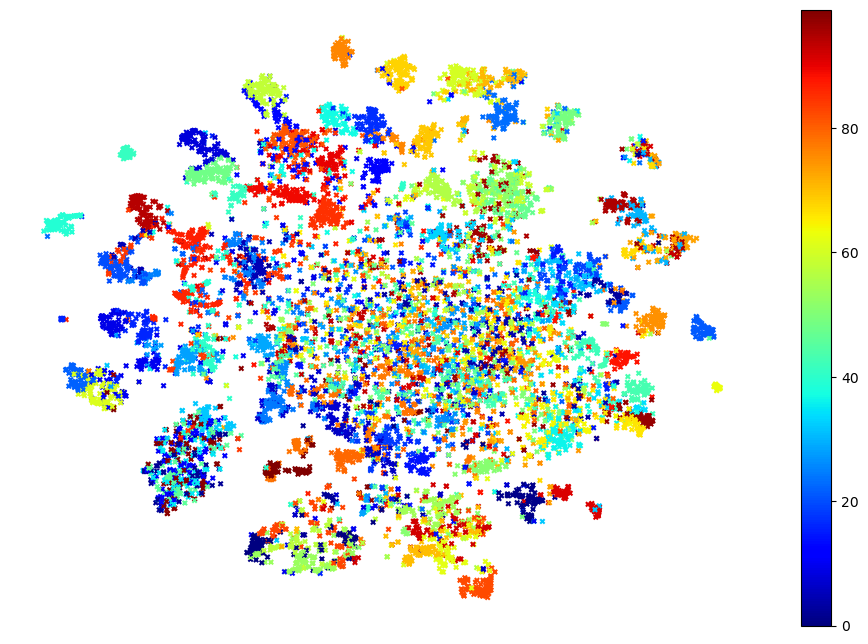

In [6]:
plt.figure(figsize=(12, 8))
plt.scatter(E_reduced[:, 0], E_reduced[:, 1], c=Ey, cmap='jet', marker='x', s=10.0)
plt.colorbar()
plt.axis('off')
plt.show()

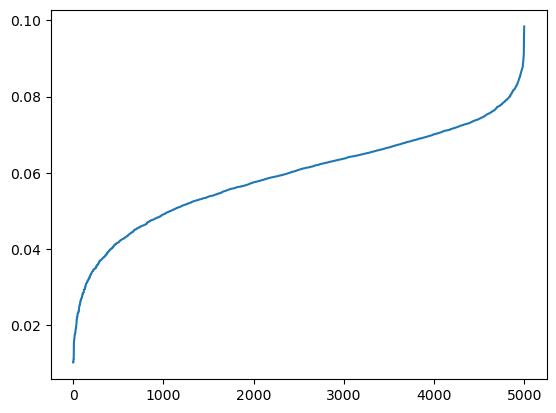

In [7]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

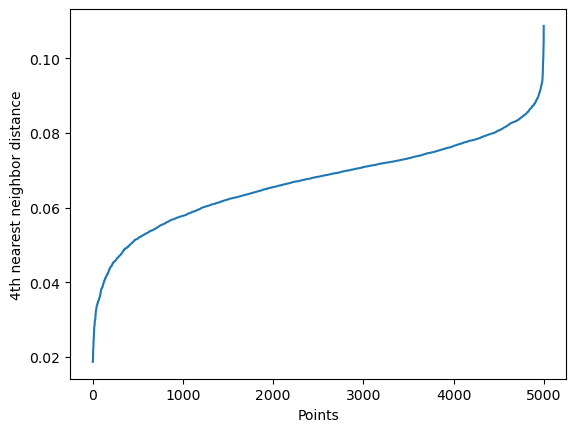

In [8]:
k = 4
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
distances, indices = nbrs.kneighbors(X)

# Sort the distances and plot them
distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)

# Find the elbow point
x = np.arange(len(distances))
eps_candidates = np.array([np.polyfit(x, distances, i)[-2] for i in range(1, 4)])
eps = eps_candidates.mean()

plt.xlabel("Points")
plt.ylabel(f"{k}th nearest neighbor distance")
plt.show()

# Use the elbow point as a starting value for min_samples
min_samples = k - 1

In [9]:
min_samples

3

In [10]:
print(X.std(axis=0))
print(X.mean(axis=0))

[0.01414214 0.01414214 0.01414214 0.01414214 0.01414214 0.01414214
 0.01414214 0.01414214 0.01414214 0.01414214 0.01414213 0.01414213
 0.01414213 0.01414213 0.01414214 0.01414214 0.01414214 0.01414214
 0.01414214 0.01414214 0.01414214 0.01414214 0.01414214 0.01414213
 0.01414214 0.01414214 0.01414214 0.01414214 0.01414214 0.01414214
 0.01414214 0.01414214 0.01414214 0.01414214 0.01414214 0.01414214
 0.01414214 0.01414214 0.01414214 0.01414214 0.01414214 0.01414213
 0.01414214 0.01414214 0.01414214 0.01414214 0.01414214 0.01414214
 0.01414214 0.01414213]
[ 4.0531159e-10  5.1259996e-10 -1.9073486e-10  0.0000000e+00
 -2.3841859e-10 -4.7683715e-11  6.1988831e-10  3.9637088e-10
 -8.0466273e-10 -2.6226044e-10  2.9206276e-10  9.0599062e-10
  9.0599062e-10 -4.8875809e-10 -1.0371208e-09 -7.7486040e-10
 -2.0861626e-10 -1.3530255e-09 -3.7550926e-10 -7.2717665e-10
 -1.2040138e-09  7.0929529e-10  1.2636184e-09  5.3644178e-10
 -5.8412553e-10 -9.9837777e-11  2.3841859e-10 -1.3709068e-09
 -1.6689300e-

In [11]:

from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import adjusted_mutual_info_score

# km = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')

# mean = np.mean(X, axis=0)
# std = np.std(X, axis=0)
# init = np.repeat(mean.reshape((1, -1)), 5, axis=0)
# init[1:] += np.random.random_sample(init[1:].shape) / std
km = KMeans(n_clusters=100)
# km = KMeans(init=init, n_clusters=init.shape[0])
A_kl = km.fit_predict(X, )
# km.fit(X)

# km = DBSCAN(eps=0.0125, min_samples=100)
# # A_kl = km.fit_predict((X - X.mean(axis=0))/(X - X.mean(axis=0)).std(axis=0))
# A_kl = km.fit_predict(X)

# gm = GaussianMixture(n_components=100).fit(X)
# A_kl = gm.predict(X)
print(A_kl.shape, y.shape)
adjusted_mutual_info_score(A_kl, y)

(5000,) (5000,)


0.5076810461515461

In [12]:
C = np.concatenate((E, X))
# C = np.concatenate((E_reduced, X_reduced))



In [13]:
# knn_labels = km.transform((C - X.mean(axis=0))/(X - X.mean(axis=0)).std(axis=0)).argmax(axis=1)
# knn_labels = km.transform(C).argmax(axis=1)
# A_kl = knn_labels[len(embedding):]
# E_kl = knn_labels[:len(embedding)]
# A_kl

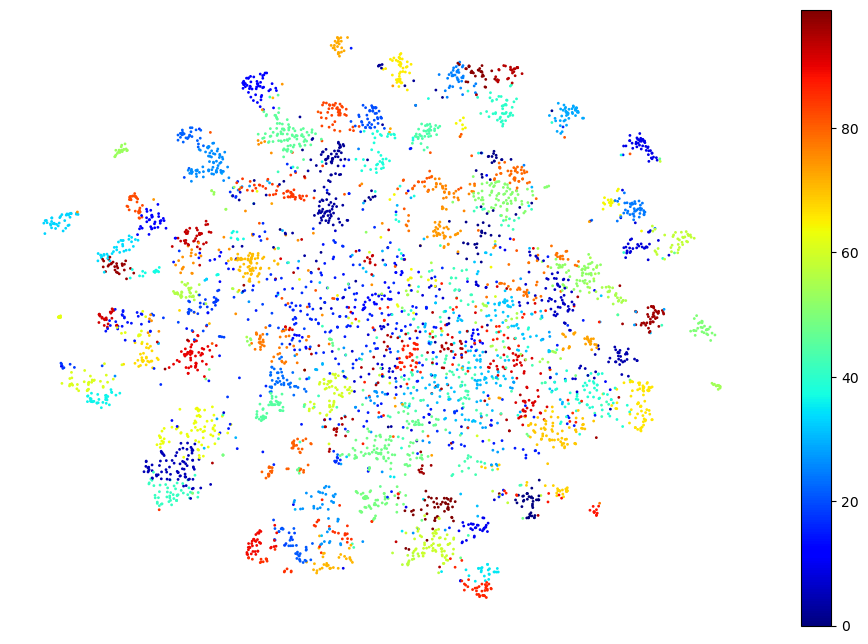

In [14]:
plt.figure(figsize=(12, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=A_kl, cmap='jet', marker='o', s=1.0)
plt.colorbar()
plt.axis('off')
plt.show()

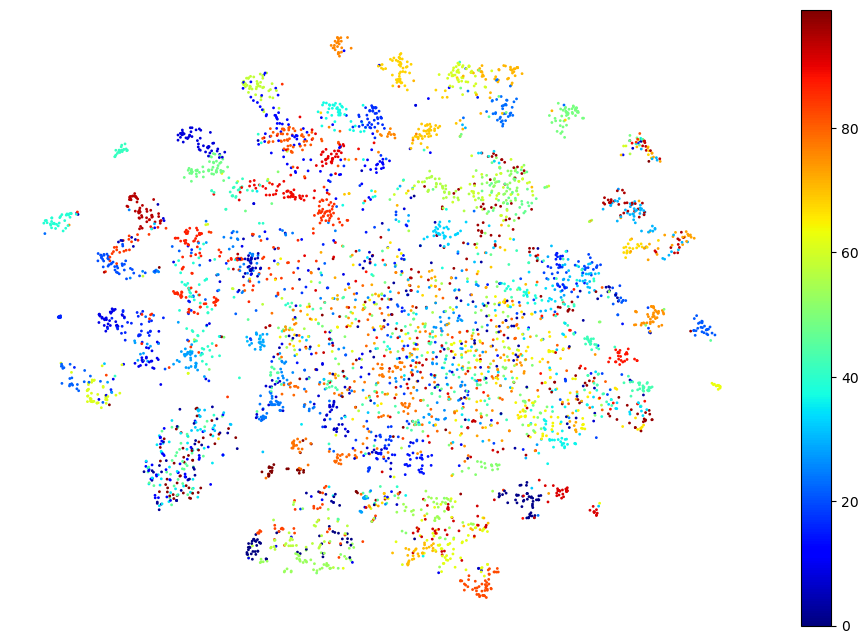

In [15]:
plt.figure(figsize=(12, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='jet', marker='o', s=1.0)
plt.colorbar()
plt.axis('off')
plt.show()

In [16]:
C.mean(axis=1)

array([-0.00031747, -0.00227501,  0.00020405, ..., -0.00015164,
        0.00086602,  0.00235916], dtype=float32)

In [70]:
cifar100classes = """aquatic mammals 	beaver, dolphin, otter, seal, whale
fish 	aquarium fish, flatfish, ray, shark, trout
flowers 	orchids, poppies, roses, sunflowers, tulips
food containers 	bottles, bowls, cans, cups, plates
fruit and vegetables 	apples, mushrooms, oranges, pears, sweet peppers
household electrical devices 	clock, computer keyboard, lamp, telephone, television
household furniture 	bed, chair, couch, table, wardrobe
insects 	bee, beetle, butterfly, caterpillar, cockroach
large carnivores 	bear, leopard, lion, tiger, wolf
large man-made outdoor things 	bridge, castle, house, road, skyscraper
large natural outdoor scenes 	cloud, forest, mountain, plain, sea
large omnivores and herbivores 	camel, cattle, chimpanzee, elephant, kangaroo
medium-sized mammals 	fox, porcupine, possum, raccoon, skunk
non-insect invertebrates 	crab, lobster, snail, spider, worm
people 	baby, boy, girl, man, woman
reptiles 	crocodile, dinosaur, lizard, snake, turtle
small mammals 	hamster, mouse, rabbit, shrew, squirrel
trees 	maple, oak, palm, pine, willow
vehicles 1 	bicycle, bus, motorcycle, pickup truck, train
vehicles 2 	lawn-mower, rocket, streetcar, tank, tractor"""
sep = list(map(lambda x: x.split('\t'), cifar100classes.split('\n')))
superclass = list(s[0].strip() for s in sep)
subclasses = list(list(map(lambda x: x.strip(), s[1].split(','))) for s in sep)
cc = {k: v for k, v in zip(superclass, subclasses)}

idxs = {k: list(label_names.index(n)
                    if n in label_names
                    else label_names.index(n[:-1].replace('poppie', 'poppy'))
                for n in
                list(l.replace(' ', '_').replace('computer_', '').replace('maple', 'maple_tree').replace('oak', 'oak_tree').replace('palm', 'palm_tree').replace('pine', 'pine_tree').replace('porcupine_tree', 'porcupine').replace('willow', 'willow_tree').replace('-', '_') for l in v)
                # if n in label_names else
                )
for k, v in cc.items()}
# idxs = {k: list(label_names.index(l.replace(' ', '_').replace('orchids', 'orchid').replace('poppies', 'poppy').replace('roses', 'rose').replace('sunflowers', 'sunflower').replace('tulips', 'tulip').replace('bottles', 'bottle').replace('bowls', 'bowl').replace('cans', 'can').replace('cups', 'cup').replace('plates', 'plate').replace('apples', 'apple').replace('mushrooms', 'mushroom').replace('oranges', 'orange')) for l in v) for k, v in cc.items()}
rcc = {}
i = 0
for k, v in idxs.items():
    print(i, k)
    for idx in v:
        rcc[idx] = i
    i+=1
y_sup = list(rcc[kk] for kk in y)


0 aquatic mammals
1 fish
2 flowers
3 food containers
4 fruit and vegetables
5 household electrical devices
6 household furniture
7 insects
8 large carnivores
9 large man-made outdoor things
10 large natural outdoor scenes
11 large omnivores and herbivores
12 medium-sized mammals
13 non-insect invertebrates
14 people
15 reptiles
16 small mammals
17 trees
18 vehicles 1
19 vehicles 2


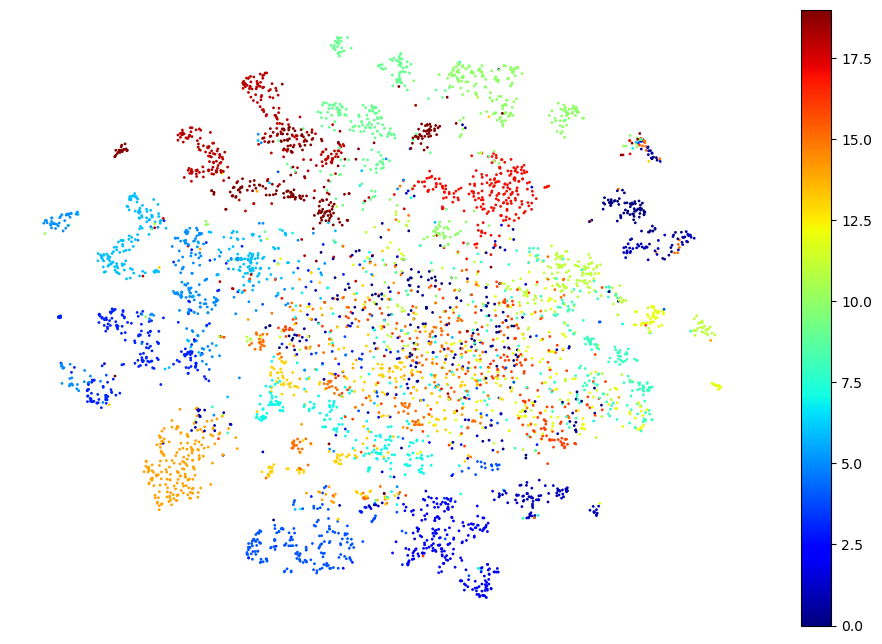

In [69]:
plt.show()
plt.figure(figsize=(12, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_sup, cmap='jet', marker='o', s=1.0)
plt.colorbar()
plt.axis('off')
plt.show()

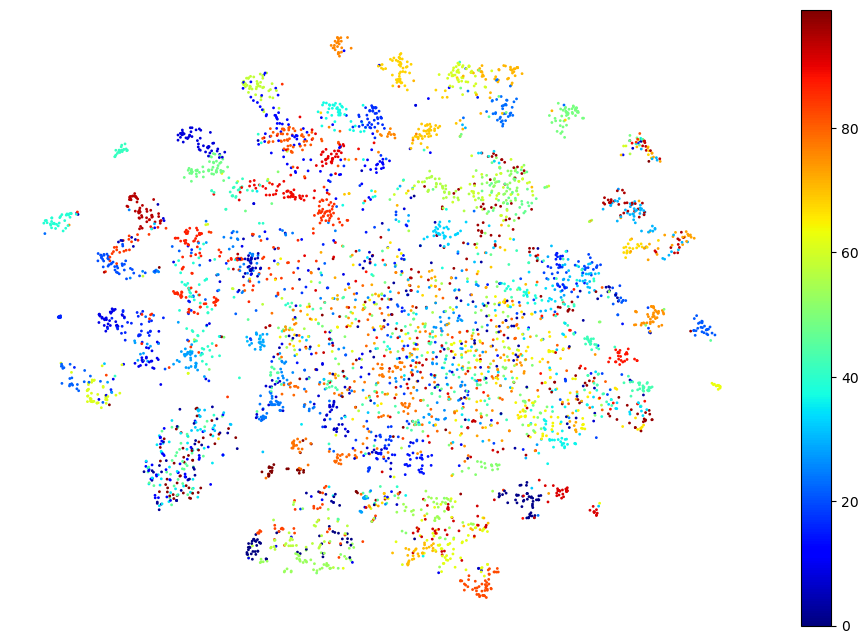

In [72]:
plt.show()
plt.figure(figsize=(12, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='jet', marker='o', s=1.0)
plt.colorbar()
plt.axis('off')
plt.show()

In [75]:
{k: list(label_names[i] for i in v) for k, v in idxs.items()}

{'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
 'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
 'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
 'food containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
 'fruit and vegetables': ['apple',
  'mushroom',
  'orange',
  'pear',
  'sweet_pepper'],
 'household electrical devices': ['clock',
  'keyboard',
  'lamp',
  'telephone',
  'television'],
 'household furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
 'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
 'large carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
 'large man-made outdoor things': ['bridge',
  'castle',
  'house',
  'road',
  'skyscraper'],
 'large natural outdoor scenes': ['cloud',
  'forest',
  'mountain',
  'plain',
  'sea'],
 'large omnivores and herbivores': ['camel',
  'cattle',
  'chimpanzee',
  'elephant',
  'kangaroo'],
 'medium-sized mammals': ['fox', 'porcupine', 'possum